In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from calc_observables import *

figwidth = 6.224
golden_ratio = 1.61803
figsize = (figwidth, figwidth / golden_ratio)
import matplotlib as mpl
sns.set_style("ticks")
sns.set_palette('colorblind')
mpl.rcParams['figure.figsize'] = figsize
mpl.rcParams['font.sans-serif'] = ['Open Sans']


path = '.\\data\\SIR\\'

In [2]:
n_pr = np.load(path+'n_pr.npy', allow_pickle=True)
params = np.load(path+'params.npz')
ps = params['ps']
reps = int(params['reps'])
# k_offblock = params['k_offblock']
ks = params['ks']

In [3]:
tmax = max(map(len, n_pr.flat))  # maximum time of epidemic
n_prnew = np.array([list(xi) + [xi[-1]] * (tmax - len(xi)) for xi in n_pr.ravel()])
n_prnew = n_prnew.reshape((len(ps), len(ks), reps, n_prnew.shape[-2], n_prnew.shape[-1]))

In [4]:
n_prnew.shape

(1, 14, 20, 366, 3)

In [5]:
axreps = 2
t_lag = 4
mean_infected = n_prnew[..., 1].mean(axreps)
std_infected = n_prnew[..., 1].std(axreps, ddof=1) #/ np.sqrt(reps)  # std of the mean of infected

mean_recovered = n_prnew[..., -1].mean(axreps)
std_recovered = n_prnew[..., -1].std(axreps, ddof=1) #/ np.sqrt(reps)
cum_infected = mean_recovered + mean_infected
std_cuminf = np.sqrt(std_recovered**2 + std_infected**2)

newcases = np.zeros_like(cum_infected)
newcases[..., 1:] = cum_infected[..., 1:] - cum_infected[..., :-1]
std_newcases = np.zeros_like(newcases)
std_newcases[..., 1:] = np.sqrt(std_cuminf[..., 1:]**2 + std_cuminf[..., :-1]**2)

r_eff = np.zeros_like(mean_infected)
r_eff[..., t_lag:] = np.divide(newcases[..., t_lag:], newcases[..., :-t_lag], where=newcases[..., :-t_lag]>0,
                               out=np.zeros_like(r_eff[..., t_lag:]))
# r_eff = np.ma.array(r_eff, mask=(newcases[..., :-t_lag]==0))
std_r = np.zeros_like(r_eff)
std_r[..., t_lag:] = np.sqrt((std_newcases[..., t_lag:] / newcases[..., :-t_lag])**2 + (newcases[..., t_lag:] / newcases[..., :-t_lag]**2 *
                                                                      std_newcases[..., :-t_lag])**2)

C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


(1, 44404.66316293481)

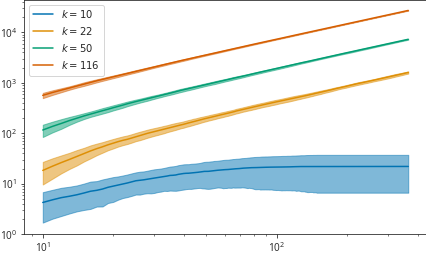

In [6]:
tmin = 10
tmax = 366
nks = n_prnew.shape[1]
for i in range(2, nks, 3):
    plot_errorshade(np.arange(tmin, tmax), cum_infected[0, i, tmin:tmax], std_cuminf[0, i, tmin:tmax], label='$k = {}$'.format(ks[i]))
    
plt.loglog()
plt.legend()
plt.ylim(1)

In [7]:
cum_infected.shape

(1, 14, 366)

In [8]:
c = np.gradient(cum_infected[0, ..., tmin:tmax], axis=-1)# .mean(axis=-1)
c = np.ma.masked_less_equal(c, 1e-1)
stdc = np.ma.masked_less_equal(c, 0).std(axis=-1, ddof=1)
c = c.mean(axis=-1)
k = np.linspace(0, ks.max()/2, num=200)
ktilde = (k+1) * (2*k + 1) / 12
# c_min = 4 * k * 0.02 * np.sqrt(ktilde)
# c_minalt = np.sqrt(8 * 0.02 * ktilde * k* (2*k*0.02 - 0.1))
c_new = np.sqrt(2 * k * ktilde * 0.02)

Text(0, 0.5, 'Wave speed $c$')

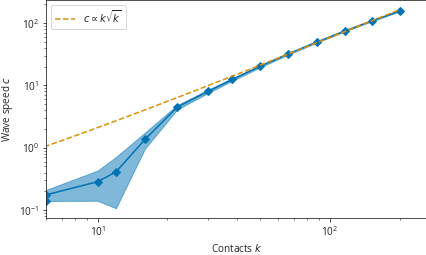

In [9]:
plot_errorshade(ks, c, stdc, marker='D')
# plt.plot(k_offblock, c)
# plt.plot(ks, ks, '--', label='$c \\propto k$')
# plt.plot(ks, ks**2, '--', label='$c \\propto k^2$')
# plt.plot(ks, ks*np.sqrt(ks), '--', label='$c \\propto k\\sqrt{k}$')
# plt.plot(k*2, 2 * c_minalt, '--', label='$c_{\\min} \\propto k^2$')
plt.plot(k*2, 2 * c_new, '--', label='$c \\propto k \\sqrt{k}$')
plt.loglog()
plt.legend()
plt.xlim(6)
# plt.ylim(0.01)
plt.xlabel('Contacts $k$')
plt.ylabel('Wave speed $c$')

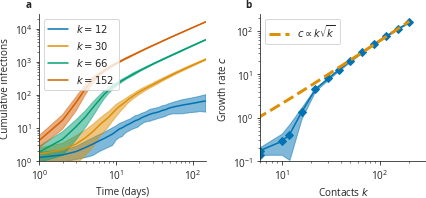

In [10]:
w = figwidth
lw = 2
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False, tight_layout=True, figsize=(w, 0.8*w/golden_ratio))
plt.sca(axs[0])
plt.loglog()
tmin = 0
tmax = 150
for i in range(0, nks, 3):
    if ks[i] > 6:
        plot_errorshade(np.arange(tmin, tmax), cum_infected[0, i, tmin:tmax], std_cuminf[0, i, tmin:tmax],
                        label='$k = {}$'.format(ks[i]))

plt.xlabel('Time (days)')
plt.ylabel('Cumulative infections')
plt.ylim(1)
plt.xlim(1, tmax)
# plt.loglog()
plt.legend()
plt.sca(axs[1])
# plt.errorbar(k_offblock, c, yerr=stdc)
# plot_errorshade(k_offblock, c, yerr=stdc)
plot_errorshade(ks, c, stdc, marker='D')
plt.plot(k*2, 2 * c_new, '--', lw=3, label='$c \\propto k\\sqrt{k}$')
plt.loglog()
plt.legend()
plt.xlim(6, ks.max()*1.5)
plt.ylim(0.1)
plt.xlabel('Contacts $k$')
plt.ylabel('Growth rate $c$')
# axs[1].set_xticks(np.arange(6, 32, 6), minor=True)
# axs[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
# axs[1].xaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.0f'))
label_axes(fig)
sns.despine()
# plt.savefig('figures\\linearregime2.pdf', bbox_inches='tight', pad_inches=0)